# ANALYSIS AND PREDICTION OF SALES DATA
![sales-prediction](trend-analysis-sales.jpg)

## INTRODUCTION

Sales forecasting plays an important role in business development. Regardless of the size of a business or the number of salespeople, accurate sales forecasting can have a significant impact on all  aspects of sales management, including planning, budgeting, and determining sales. In most densely  populated cities, where the number of stores is growing, sound sales forecasting helps stores develop scientific and effective sales strategies to increase store revenues and reduce unnecessary losses.


## Data and Methods

The data scientists at Big Mart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and predict the sales of each product at a particular outlet. Using this model, Big Mart will try to understand the properties of products and outlets which play a key role in increasing sales.

Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly.

## Content
The dataset provides the product details and the outlet information of the products purchased with their sales value split into a train set (8523) and a test (5681) set.
Train file: CSV containing the item outlet information with sales value
Test file: CSV containing item outlet combinations for which sales need to be forecasted

### Variable Description

+ ProductID : unique product ID
+ Weight : weight of products
+ FatContent : specifies whether the product is low on fat or not
+ Visibility : percentage of total display area of all products in a store allocated to the particular product
+ ProductType : the category to which the product belongs
+ MRP : Maximum Retail Price (listed price) of the products
+ OutletID : unique store ID
+ EstablishmentYear : year of establishment of the outlets
+ OutletSize : the size of the store in terms of ground area covered
+ LocationType : the type of city in which the store is located
+ OutletType : specifies whether the outlet is just a grocery store or some sort of supermarket
+ OutletSales : (target variable) sales of the product in the particular store

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')



In [9]:
# create a few fucntion for analysis
# create a function for exploring data types, number of NaN and other statistical values
def explore(df):
    """
    Function to explore a pandas DataFrame and return a summary table of each column.

    Parameters:
    -----------
    df: pandas DataFrame
        The DataFrame to be explored.

    Returns:
    --------
    ret: pandas DataFrame
        A summary table of each column containing its type, minimum and maximum values,
        percentage of NaN values, number of values, and unique values.
    """
    ret = pd.DataFrame(columns=['Type',"Nan %",
                                '# Values'])
    for col , content in df.items():
        values= []
        values.append(content.dtype) #look for actual type
        values.append(df[col].isnull().sum()/len(df[col]) *100) #% of Nan's
        values.append(content.nunique()) #count # of uniques
        
        ret.loc[col]=values
        
    return ret

In [3]:
# create a function that sets the caption of a figure
def set_fig_caption(fig,fig_number,x=0,y=-0.01,gap=0.05,title=None,caption:str=None,size=8):
    """
    Function to set the caption of a matplotlib figure.

    Parameters:
    -----------
    fig: matplotlib figure
        The figure to set the caption for.
    fig_number: int
        The number of the figure.
    x: float, optional
        The x position of the caption.
    y: float, optional
        The y position of the caption.
    gap: float, optional
        The gap between the title and the caption.
    title: str, optional
        The title of the figure.
    caption: str, optional
        The caption of the figure.
    size: int, optional
        The size of the text.

    Returns:
    --------
    fig: matplotlib figure
        The figure with the caption set.
    """
    if not title:
        title=''
    fig.text(x,y,f'Figure {fig_number}. {title.title()}', # text parameters
             weight='bold',size=size+1)
    if caption: 
        for i in np.arange(caption.count('\n')): y -= 0.02 
        fig.text(x,y-gap,caption,color='#474949',
                 ma='left',wrap=True,size=size)
    return fig

In [4]:
# read the data and print out the first few rows 
bigdata = pd.read_csv('BigMart Sales Data.csv')

# make a copy of the data
bigmart = bigdata.copy()
bigmart.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## DATA CLEANING


The data has 12 columns with 8523 entries. The following could be deducted form the initial exploration
+ All the columns have no missing values except the **Item_Weight* and **Outlet_Size** columns both having 17.16% and 28.27% of their values missing respectively. 
+ The store sells 1559 unique items or products. This is too many to be useful, we need to see how we can categorise them into a smaller number of groups 
+ in the Item_Fat_Content column, there appears to be inconsistencies in the data as **Low Fat** is also represented as *LF* or **low fat** in some rows. We can also see **Regular** being represented as **reg** in some rows. We will use **Low Fat** and **Regular** as replacement for these to ensure data quality.
+ The min value of Item_Visibility is 0, but this can not be as every item must have some visibility.
+ There are only 16 Item_Type.
+ There are 10 stores.

In [14]:
bigmart.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [10]:
# check for missing vlaues and data type
explore(bigmart)

,Type,Nan %,# Values
Item_Identifier,object,0.000000,1559
Item_Weight,float64,17.165317,415
Item_Fat_Content,object,0.000000,5
Item_Visibility,float64,0.000000,7880
Item_Type,object,0.000000,16
Item_MRP,float64,0.000000,5938
Outlet_Identifier,object,0.000000,10
Outlet_Establishment_Year,int64,0.000000,9
Outlet_Size,object,28.276428,3
Outlet_Location_Type,object,0.000000,3


In [12]:
# check the summary statistics of the data
bigmart.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [13]:
# lets check check unique value of tha caegorical columns
# to see if there are inconsistencies
bigmart.Item_Fat_Content.unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

Further Observations include:
+ Stores with Outlet_Identifier OUT010 and OUT019 have significantly smaller number of sales.

In [16]:
# check the frequncy of each dfferent category in each nominal value
# filtert  the categorical variables

cat_columns = [x for x in bigmart.dtypes.index if bigmart.dtypes[x] == 'object']

# exclude the Item_Identifier column
cat_columns = [x for x in cat_columns if x != 'Item_identifier']

# print frequencies of categories
for col in cat_columns:
    print('\nFrequency of Categories for {}'.format(col))
    print(bigmart[col].value_counts())


Frequency of Categories for Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64

Frequency of Categories for Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

Frequency of Categories for Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

Frequency of Categories for Outlet_Identifier
OUT027    935


### Imputing Missing Values


**Item_Weight**

Assuming each Item_Identifier identifies a specific item, then it seems reasonable to impute the missing values of the Item_Weight by the average Item_Weight of each Item_Identifier.

To check that we have imputed the values in a reasonable way, we can check the average weight per Outlet_Identifier before and after imputing the missing values.

The graph below shows that the missing weights affects two outlets (**OUT019** and **OUT027**). It can be seen that each outlet has almost the same average values and distribution

<Axes: title={'center': 'Item_Weight'}, xlabel='Outlet_Identifier'>

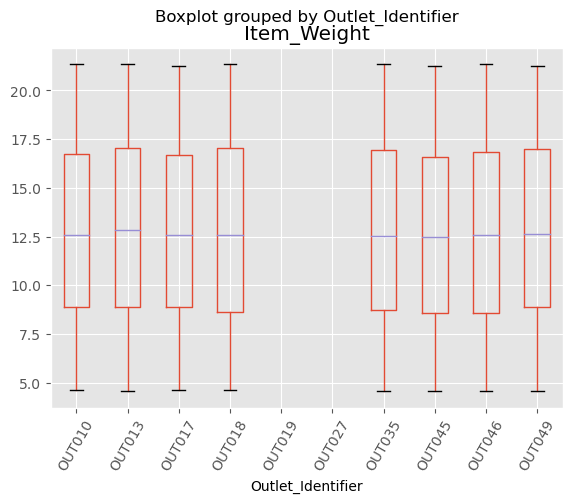

In [18]:
bigmart.boxplot(column = 'Item_Weight', by = 'Outlet_Identifier',
            rot = 60)

In [20]:
# let get the average weigth per item
item_avg_weight = bigmart.pivot_table(values = 'Item_Weight', index = 'Item_Identifier')
item_avg_weight.head()

,Item_Weight
Item_Identifier,
DRA12,11.600
DRA24,19.350
DRA59,8.270
DRB01,7.390
DRB13,6.115


In [21]:
# create a mask of the misssing values
null_mask_weight = bigmart['Item_Weight'].isnull()

# impute values
bigmart.loc[null_mask_weight, 'Item_Weight'] = bigmart.loc[null_mask_weight, 'Item_Identifier']\
                                                .apply(lambda x: item_avg_weight[x])

KeyError: 'FDP10'

In [22]:
bigmart[bigmart['Item_Identifier'] == 'FDP10']

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
585,FDP10,19.0,Low Fat,0.128066,Snack Foods,104.3622,OUT035,2004,Small,Tier 2,Supermarket Type1,1905.5196
2623,FDP10,19.0,Low Fat,0.128815,Snack Foods,107.6622,OUT017,2007,NaN,Tier 2,Supermarket Type1,1164.4842
3382,FDP10,19.0,Low Fat,0.128289,Snack Foods,104.9622,OUT049,1999,Medium,Tier 1,Supermarket Type1,1164.4842
4585,FDP10,19.0,Low Fat,0.128090,Snack Foods,107.0622,OUT046,1997,Small,Tier 1,Supermarket Type1,1376.2086
6087,FDP10,19.0,Low Fat,0.128350,Snack Foods,106.5622,OUT045,2002,NaN,Tier 2,Supermarket Type1,1482.0708
7883,FDP10,19.0,Low Fat,0.127984,Snack Foods,107.6622,OUT013,1987,High,Tier 3,Supermarket Type1,1270.3464
